In [1]:
import numpy as np
import pandas as pd
import tensorflow.keras as K
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    if len(filenames) != 0:
        print(f"Total Files in {dirname}", len(filenames))

Total Files in /kaggle/input/dogs-cats-images/dog vs cat/dataset/training_set/cats 4000
Total Files in /kaggle/input/dogs-cats-images/dog vs cat/dataset/training_set/dogs 4000
Total Files in /kaggle/input/dogs-cats-images/dog vs cat/dataset/test_set/cats 1000
Total Files in /kaggle/input/dogs-cats-images/dog vs cat/dataset/test_set/dogs 1000
Total Files in /kaggle/input/dogs-cats-images/dataset/training_set/cats 4000
Total Files in /kaggle/input/dogs-cats-images/dataset/training_set/dogs 4000
Total Files in /kaggle/input/dogs-cats-images/dataset/test_set/cats 1000
Total Files in /kaggle/input/dogs-cats-images/dataset/test_set/dogs 1000


In [2]:
generator = ImageDataGenerator(rescale = 1./255)

train_set = generator.flow_from_directory("../input/dogs-cats-images/dataset/training_set",
                                          class_mode = "binary",
                                          batch_size = 32,
                                          target_size = (224, 224))

val_set = generator.flow_from_directory("../input/dogs-cats-images/dataset/test_set",
                                        batch_size = 32,
                                        class_mode = "binary",
                                        target_size = (224, 224))

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [3]:
x_train, y_train = next(train_set)
x_test, y_test = next(val_set)

x_train.shape, y_train.shape

((32, 224, 224, 3), (32,))

In [4]:
np.unique(y_train)

array([0., 1.], dtype=float32)

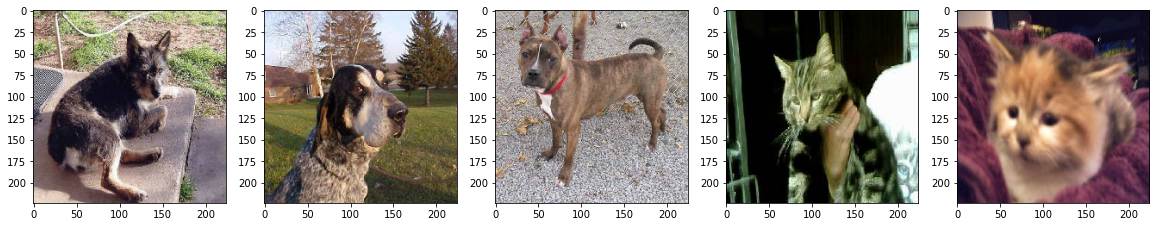

In [5]:
plt.figure(figsize = (20, 6))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_set[0][0][i])

plt.show()

In [6]:
from tensorflow.keras.layers import (Conv2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Lambda, AveragePooling2D, 
                                     Dense, Flatten, Input)

CLASSES = 2
EPOCHS = 50
INPUT_SIZE = (224, 224, 3)
EPOCH_STEPS = int(len(train_set) / 32)


def inception_block(x, ft_1x1, ft_3x3_red, ft_3x3, ft_5x5_red, ft_5x5, pool_proj, activation):
    conv_1x1 = Conv2D(ft_1x1, (1, 1), (1, 1), padding='same', activation=activation)(x)
    
    conv_3x3_red = Conv2D(ft_3x3_red, (1, 1), (1, 1), padding='same', activation=activation)(x)
    conv_3x3 = Conv2D(ft_3x3, (3, 3), (1, 1), padding='same', activation=activation)(conv_3x3_red)
    
    conv_5x5_red = Conv2D(ft_5x5_red, (1, 1), (1, 1), padding='same', activation=activation)(x)
    conv_5x5 = Conv2D(ft_5x5, (5, 5), (1, 1), padding='same', activation=activation)(conv_5x5_red)
    
    mx_pool = MaxPooling2D((3, 3), (1, 1), padding='same')(x)
    conv_1x1_pp = Conv2D(pool_proj, (1, 1), (1, 1), padding='same', activation=activation)(mx_pool)
    
    out = K.layers.concatenate([conv_1x1, conv_3x3, conv_5x5, conv_1x1_pp], axis=3)
    
    return out


def side_branch(x, activation, id_):
    avg_pool = AveragePooling2D((5, 5), (3, 3))(x)
    cv_1x1 = Conv2D(128, (1, 1), (1, 1), padding='same')(avg_pool)
    flt = Flatten()(cv_1x1)
    fc = Dense(1000, activation=activation)(flt)
    dp = Dropout(0.4)(fc)
    
    out = Dense(CLASSES, activation='softmax', name=f'softmax{id_}')(dp)
    
    return out


def inception_net(input_size=INPUT_SIZE, activation='relu'):
    LRN = Lambda(tf.nn.local_response_normalization)
    
    inp = Input(shape=input_size)
    model = Conv2D(64, (7, 7), (2, 2), padding='same', input_shape=input_size, activation=activation)(inp)
    model = MaxPooling2D((3, 3), (2, 2), padding='same')(model)
    model = LRN(model)
    model = Conv2D(64, (1, 1), (1, 1), activation=activation)(model)
    model = Conv2D(192, (3, 3), (1, 1), padding='same', activation=activation)(model)
    model = LRN(model)
    model = MaxPooling2D((3, 3), (2, 2), padding='same')(model)
    model = inception_block(model, 64, 96, 128, 16, 32, 32, activation)
    model = inception_block(model, 128, 128, 192, 32, 96, 64, activation)
    model = MaxPooling2D((3, 3), (2, 2), padding='same')(model)
    model = inception_block(model, 192, 96, 208, 16, 48, 64, activation)
    sb0  = side_branch(model, activation, id_=0)
    model = inception_block(model, 160, 112, 224, 24, 64, 64, activation)
    model = inception_block(model, 128, 128, 256, 24, 64, 64, activation)
    model = inception_block(model, 112, 144, 288, 32, 64, 64, activation)
    sb1  = side_branch(model, activation, id_=1)
    model = inception_block(model, 256, 160, 320, 32, 128, 128, activation)
    model = MaxPooling2D((3, 3), (2, 2), padding='same')(model)
    model = inception_block(model, 256, 160, 320, 32, 128, 128, activation)
    model = inception_block(model, 384, 192, 384, 48, 128, 128, activation)
    model = AveragePooling2D((7, 7), (1, 1))(model)
    model = Dropout(0.4)(model)
    model = Flatten()(model)
    model = Dense(1000, activation=activation)(model)
    model = Dense(CLASSES, activation='softmax', name='softmax2')(model)
    
    return K.Model(inputs=inp, outputs=[model, sb0, sb1], name='inception-net-v1')

In [7]:
icn = inception_net()
icn.compile(
    optimizer='adam', 
    loss="binary_crossentropy", 
    loss_weights={'softmax2': 1.0, 'softmax1': 0.3, 'softmax2': 0.3}, 
    metrics=['accuracy']
)

icn.summary()

Model: "inception-net-v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
lambda (Lambda)                 multiple             0           max_pooling2d[0][0]              
                                                                 conv2d_2[0][0]    

In [8]:
history = icn.fit(
    x_train, [y_train, y_train, y_train],
    validation_data=(x_test, [y_test, y_test, y_test]),
    steps_per_epoch=EPOCH_STEPS,
    epochs=EPOCHS
)

Epoch 1/50
7/7 [==============================] - 5s 749ms/step - loss: 1.1120 - softmax2_loss: 0.6932 - softmax0_loss: 0.6960 - softmax1_loss: 0.6935 - softmax2_accuracy: 0.5000 - softmax0_accuracy: 0.5625 - softmax1_accuracy: 0.3750 - val_loss: 1.1092 - val_softmax2_loss: 0.6932 - val_softmax0_loss: 0.6933 - val_softmax1_loss: 0.6932 - val_softmax2_accuracy: 0.6250 - val_softmax0_accuracy: 0.3750 - val_softmax1_accuracy: 0.3750
Epoch 2/50
7/7 [==============================] - 4s 633ms/step - loss: 1.1092 - softmax2_loss: 0.6932 - softmax0_loss: 0.6933 - softmax1_loss: 0.6932 - softmax2_accuracy: 0.5625 - softmax0_accuracy: 0.4375 - softmax1_accuracy: 0.6562 - val_loss: 1.1090 - val_softmax2_loss: 0.6932 - val_softmax0_loss: 0.6932 - val_softmax1_loss: 0.6932 - val_softmax2_accuracy: 0.6250 - val_softmax0_accuracy: 0.3750 - val_softmax1_accuracy: 0.6250
Epoch 3/50
7/7 [==============================] - 5s 673ms/step - loss: 1.1091 - softmax2_loss: 0.6932 - softmax0_loss: 0.6932 - sof

In [9]:
def show_train_history(history, xlabel, ylabel, train, suffix):
    for item in train:
        plt.plot(history[item + '_' + suffix])

    plt.title('Train History')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(train, loc='upper left')
    plt.show()

In [10]:
history_all = history.history
history_all.keys()

dict_keys(['loss', 'softmax2_loss', 'softmax0_loss', 'softmax1_loss', 'softmax2_accuracy', 'softmax0_accuracy', 'softmax1_accuracy', 'val_loss', 'val_softmax2_loss', 'val_softmax0_loss', 'val_softmax1_loss', 'val_softmax2_accuracy', 'val_softmax0_accuracy', 'val_softmax1_accuracy'])

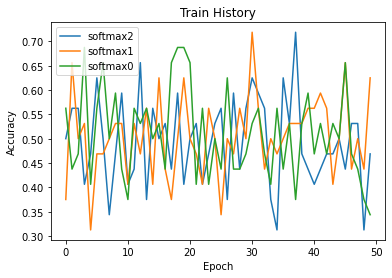

In [11]:
show_train_history(history_all, 'Epoch', 'Accuracy', ('softmax2', 'softmax1', 'softmax0'), 'accuracy')

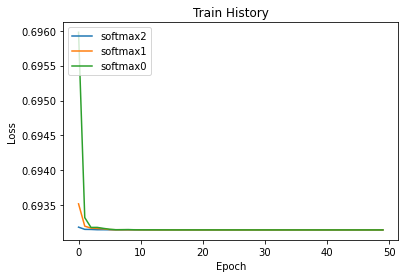

In [12]:
show_train_history(history_all, 'Epoch', 'Loss', ('softmax2', 'softmax1', 'softmax0'), suffix='loss')